# King County Housing Linear Regression Model

### Morgan Fell 

## Overview

Home and Garden Television (HGTV) is interested in filming around the Seattle, WA area. In preparation, we have gathered historical home data for King County, WA to have an understanding of the market. Through our analysis we hope to provide stakeholders with evidence of target home features, renovation return on investment, and overall pricing. Shows on the network range from Home Hunters, where a family explores 3-4 options to buy, to house flipping. In order to front the budget for these shows, our stakeholders need to understand if this area is worth the expense. 

## Questions

Our exploration and linear regression model will focus on these questions:
1. How many homes are available for renovation and what is the historical ROI for renovated homes?
2. Should our crews focus more on structural features (living space, bathrooms, bedrooms, etc.) or landscape (views, acres, garage, patio, etc.)
3. Where in King County should we focus? 

# Data Exploration 

In [183]:
#importing necessary libriaries 
import pandas as pd #pandas will provide help with data manipulation
import numpy as np #allows quick operations on numerical data
import seaborn as sns #helps with data visualization
import matplotlib.pyplot as plt #plotting data tool
import folium #data visualization on a map
import scipy.stats as stats 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import PolynomialFeatures

In [184]:
king_raw = pd.read_csv("kc_house_data.csv") #assigning data to a pandas dataframe 
king_raw.head() #printing the first 5 rows of data from newly assigned dataframe 

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188


In [185]:
king_raw.info() #provides a summary of the dataframe so that we can understand the complete size, any missing data, and the data type of each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

So, we can see that heat_source and sewer_system have a few null values we may need to replace. We also want to change the date to a numerical data type so that we can utilize the timing of purchase. Our next steps will be to describe each of the numerical columns so that we gain an idea of statistical values. 

Let's look at the distribution of our values

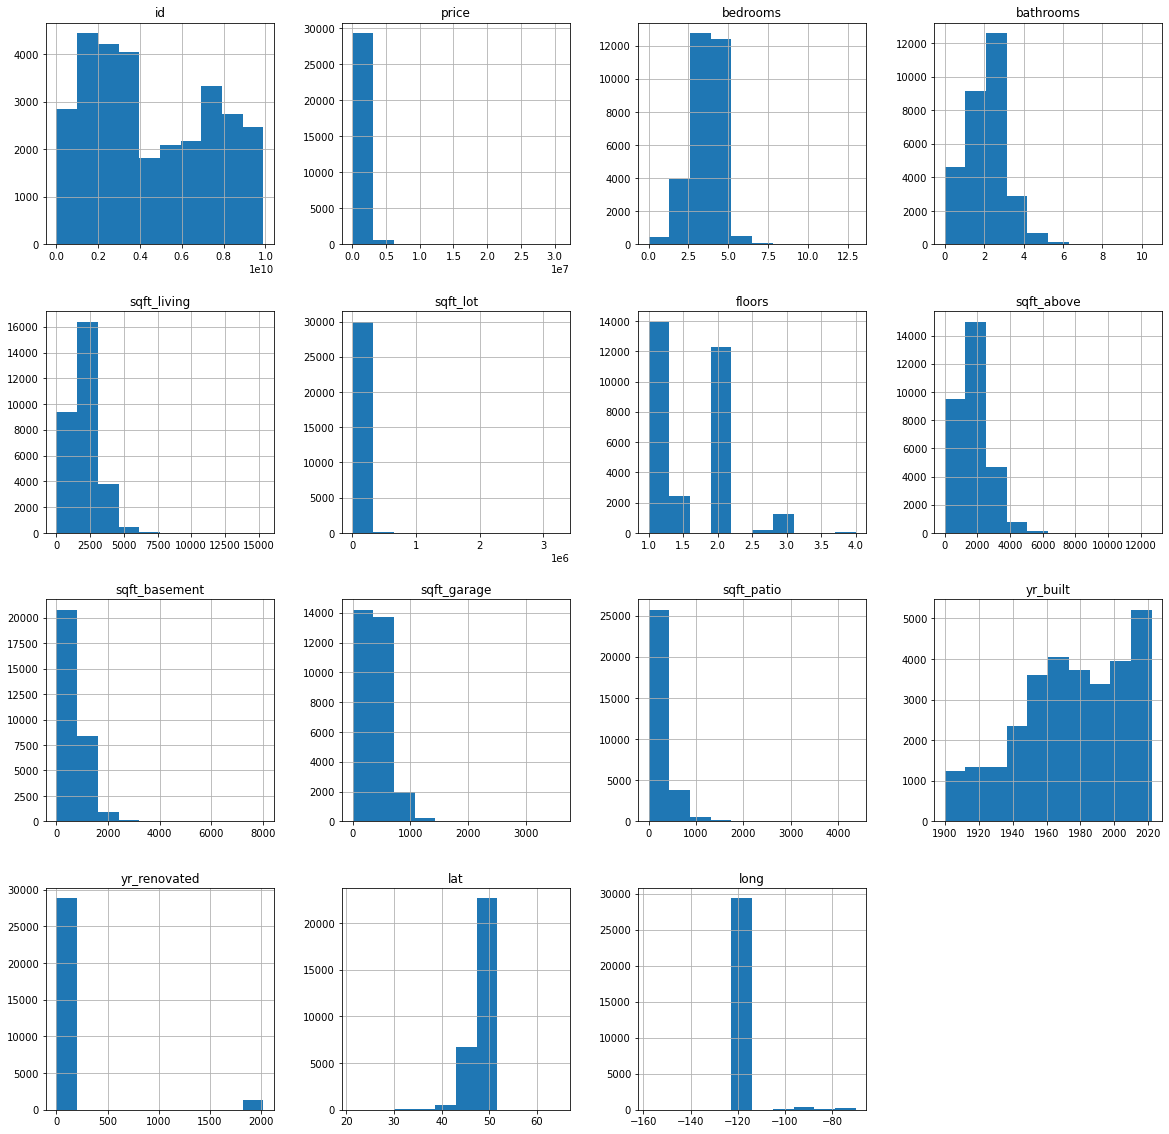

In [186]:
king_raw.hist(figsize=(20,20));

Almost all of our values do not have a normal distribution, which can create issues when performing linear regressions. I will address these distributions as we move into modeling. 

# Data Cleaning

I'm going to create a copy of the raw dataframe, then I want to start by clearing out the null values.

In [187]:
clean_king = king_raw.copy() #Creates a new dataframe that is a copy of the raw data

In [188]:
# Count number of duplicated IDs in the clean_king dataframe
print("Number of duplicated id's :", clean_king.id.duplicated(keep=False).sum())

Number of duplicated id's : 2


In [189]:
clean_king.isna().sum() #returns the total number of null values in each column

id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source      32
sewer_system     14
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
dtype: int64

Our data set has 30,155 entries. Seeing how few null values there are our first instinct might be to drop those rows; however, we don't want to risk decreasing the value of the other information in those rows. I'm going to look at the categories of data within both columns then convert the nulls to 'no' or '0'

In [190]:
clean_king.heat_source.value_counts() #Totals for the categories of heat_sources

Gas                  20583
Electricity           6465
Oil                   2899
Gas/Solar               93
Electricity/Solar       59
Other                   20
Oil/Solar                4
Name: heat_source, dtype: int64

In [191]:
clean_king['heat_source'] = clean_king['heat_source'].fillna('Other') #replaces any null values with Other

In [192]:
clean_king.heat_source.value_counts() #checks the column for increase to see if the replacement worked

Gas                  20583
Electricity           6465
Oil                   2899
Gas/Solar               93
Electricity/Solar       59
Other                   52
Oil/Solar                4
Name: heat_source, dtype: int64

In [193]:
clean_king.isna().sum() #checks for null value changes

id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source       0
sewer_system     14
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
dtype: int64

In [194]:
clean_king.sewer_system.value_counts() #total for all categories in column

PUBLIC                25777
PRIVATE                4355
PRIVATE RESTRICTED        6
PUBLIC RESTRICTED         3
Name: sewer_system, dtype: int64

In [195]:
clean_king.loc[king_raw.sewer_system.isnull(), 'sewer_system'] = "NONE" #replaces null with NONE
clean_king.sewer_system.value_counts() #checks for new NONE category

PUBLIC                25777
PRIVATE                4355
NONE                     14
PRIVATE RESTRICTED        6
PUBLIC RESTRICTED         3
Name: sewer_system, dtype: int64

In [196]:
clean_king.isna().sum() #checks for null value changes

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
greenbelt        0
nuisance         0
view             0
condition        0
grade            0
heat_source      0
sewer_system     0
sqft_above       0
sqft_basement    0
sqft_garage      0
sqft_patio       0
yr_built         0
yr_renovated     0
address          0
lat              0
long             0
dtype: int64

In [197]:
# Change to datetime and add month column
clean_king['date'] = pd.to_datetime(clean_king['date'])
clean_king['month'] = pd.DatetimeIndex(clean_king['date']).month

In [198]:
# Add house_age column by subtracting the year built from the date sold
clean_king['age'] = clean_king['date'].dt.year - clean_king['yr_built']

#Change waterfront to numerical values
clean_king['waterfront'] = clean_king['waterfront'].apply(lambda x: 0 if x == 'NO' else 1)

# Change view missing value to NONE, then to numerical ordered values.
view_dict = {'NONE':0, 'FAIR':1, 'AVERAGE':2, 'GOOD':3, 'EXCELLENT':4}
clean_king['view'].replace(view_dict, inplace=True)

# Change condition to numerical ordered values.
cond_dict = {'Poor':0, 'Fair':1, 'Average':2, 'Good':3, 'Very Good':4}
clean_king['condition'].replace(cond_dict, inplace=True)

# Change grade to numerical ordered values.
clean_king['grade'] = clean_king['grade'].map(lambda x: int(x.split(' ')[0]))

#Adds a column for 'if renovated' 
clean_king['renovated'] = clean_king['yr_renovated'].apply(lambda x: 0 if x == 0 else 1)

In [199]:
#Descriptive statistics to check the distribution and if outliers might be present
clean_king.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,month,age,renovated
count,3.015500e+04,3.015500e+04,30155.000000,30155.000000,30155.000000,3.015500e+04,30155.000000,30155.000000,30155.000000,30155.000000,...,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000
mean,4.538104e+09,1.108536e+06,3.413530,2.334737,2112.424739,1.672360e+04,1.543492,0.017211,0.295009,2.471298,...,476.039396,330.211142,217.412038,1975.163953,90.922301,47.328076,-121.317397,6.876969,46.196253,0.045498
std,2.882587e+09,8.963857e+05,0.981612,0.889556,974.044318,6.038260e+04,0.567717,0.130059,0.854268,0.702517,...,579.631302,285.770536,245.302792,32.067362,416.473038,1.434005,5.725475,3.113640,32.082180,0.208398
min,1.000055e+06,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1900.000000,0.000000,21.274240,-157.791480,1.000000,-1.000000,0.000000
25%,2.064175e+09,6.480000e+05,3.000000,2.000000,1420.000000,4.850000e+03,1.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,40.000000,1953.000000,0.000000,47.405320,-122.326045,4.000000,18.000000,0.000000
50%,3.874011e+09,8.600000e+05,3.000000,2.500000,1920.000000,7.480000e+03,1.500000,0.000000,0.000000,2.000000,...,0.000000,400.000000,150.000000,1977.000000,0.000000,47.551380,-122.225585,7.000000,44.000000,0.000000
75%,7.287100e+09,1.300000e+06,4.000000,3.000000,2619.500000,1.057900e+04,2.000000,0.000000,0.000000,3.000000,...,940.000000,510.000000,320.000000,2003.000000,0.000000,47.669913,-122.116205,9.000000,68.000000,0.000000
max,9.904000e+09,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,1.000000,4.000000,4.000000,...,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000,64.824070,-70.074340,12.000000,122.000000,1.000000


# Data Visualization

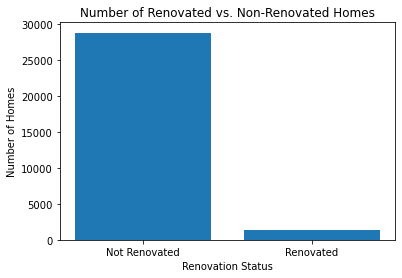

In [200]:
# Count the number of renovated and non-renovated homes in clean_king
renovated_counts = clean_king['renovated'].value_counts()

# Create a bar chart showing the number of renovated vs. non-renovated homes
fig, ax = plt.subplots()
ax.bar(['Not Renovated', 'Renovated'], renovated_counts.values)
ax.set_xlabel('Renovation Status')
ax.set_ylabel('Number of Homes')
ax.set_title('Number of Renovated vs. Non-Renovated Homes')
plt.show()

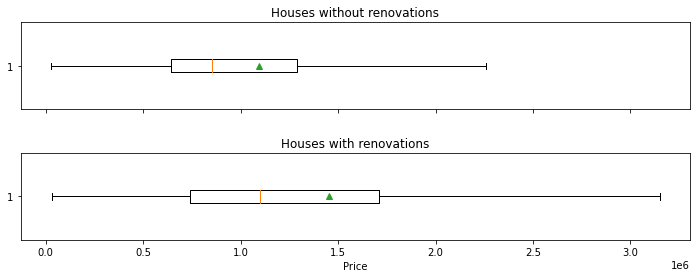

House prices without renovations median: $ 851450
House prices with renovations median: $ 1100000
Percentage increase in price with renovations 29 %


In [201]:
#Create two sets of data, one for transactions without renovations (woreno) and one with renovations(reno).
prices_woreno = clean_king[clean_king['renovated']== 0].price
prices_reno = clean_king[clean_king['renovated']!= 0].price
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (12,4), sharex=True)

#Create boxplot without outliers for better visualization.
ax1.boxplot(prices_woreno, vert=False, showfliers=False, showmeans=True)
ax2.boxplot(prices_reno,vert=False, showfliers=False, showmeans=True)
ax1.set_title('Houses without renovations')
ax2.set_title('Houses with renovations')
plt.xlabel('Price')
plt.subplots_adjust(hspace=0.50)
plt.show()
print('House prices without renovations median: $',int(prices_woreno.median()))
print('House prices with renovations median: $',int(prices_reno.median()))
print('Percentage increase in price with renovations',
      int(float((prices_reno.median()-prices_woreno.median())/prices_woreno.median())*100),'%')

In [202]:
from scipy.stats import ttest_ind

# Split the data into two groups based on renovation status
renovated = clean_king[clean_king['renovated'] == True]['price']
not_renovated = clean_king[clean_king['renovated'] == False]['price']

# Perform two-sample t-test
t_statistic, p_value = ttest_ind(renovated, not_renovated)

# Print the results
print("t-statistic: ", t_statistic)
print("p-value: ", p_value)


t-statistic:  14.728437672220887
p-value:  6.264953604125648e-49


The t-test results show that the calculated t-statistic is 14.7, and the associated p-value is 6.2e-49. The t-statistic indicates the difference between the means of the two groups, and the p-value represents the probability of obtaining such a difference if the null hypothesis is true.

Since the p-value of is less than the significance level of 0.05, we can reject the null hypothesis that the mean price of renovated and non-renovated homes are equal. Therefore, we can conclude that there is significant difference in price between renovated and non-renovated homes in King County.

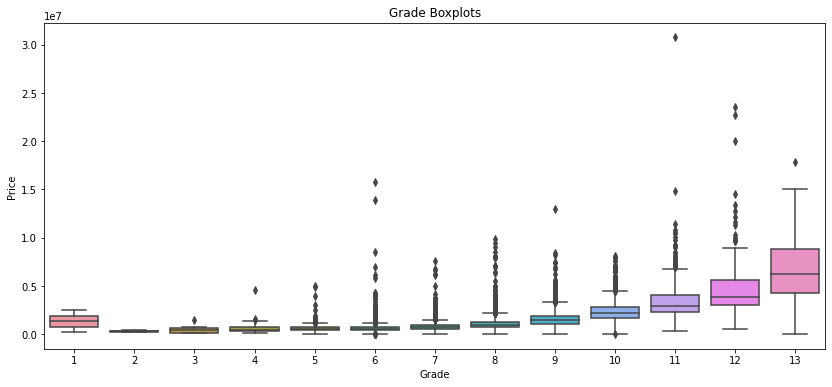

In [203]:
#Create a subset of the database with the variables needed for the analysis.
plt.figure(figsize=(14, 6))
sns.boxplot(x='grade', y='price', data=clean_king)
plt.title('Grade Boxplots')
plt.ylabel('Price')
plt.xlabel('Grade')
plt.show()

It looks like there is a slight linear relationship between grade and price. 

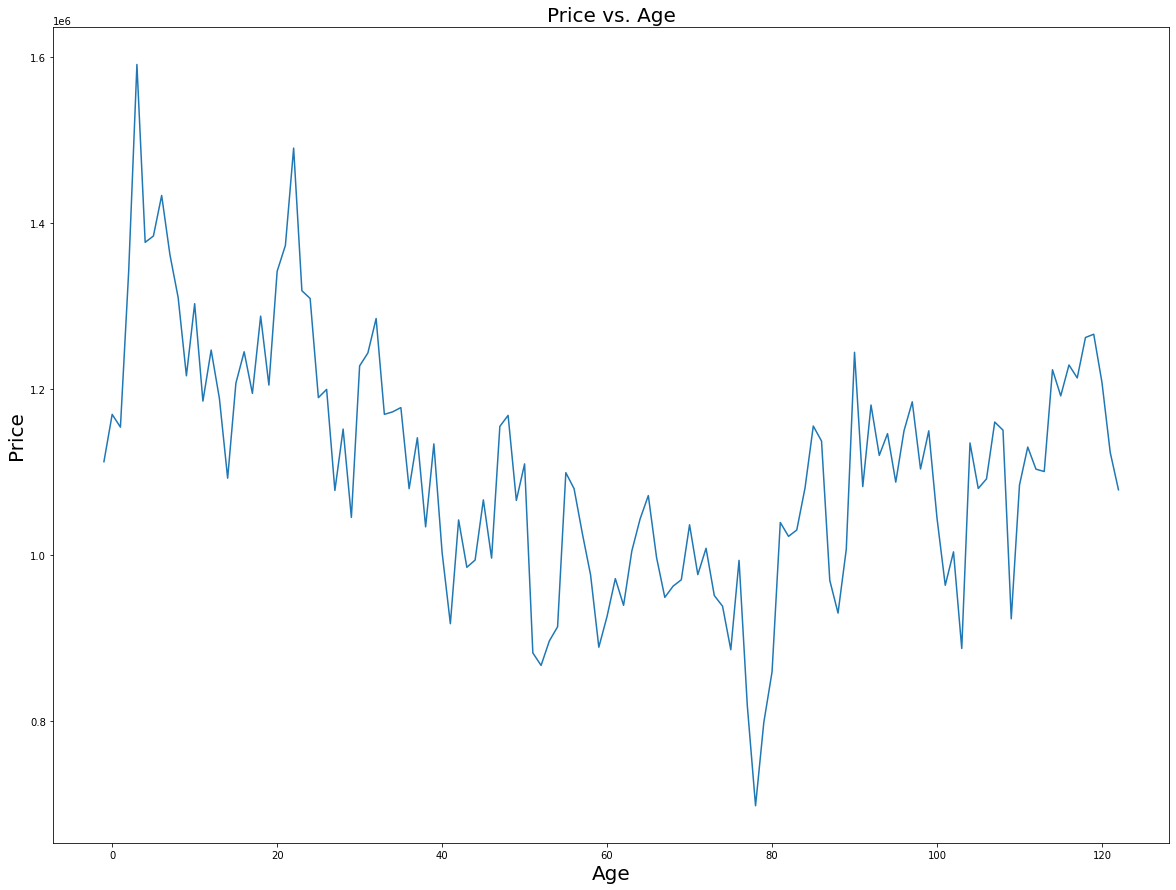

In [204]:
#Groups by sqft_living and calculate the mean price
sqft_price = clean_king.groupby('age')['price'].mean()

#Creates a line plot
fig = plt.figure(figsize=(20,15))
plt.plot(sqft_price.index, sqft_price.values)


plt.title('Price vs. Age', fontsize=20)
plt.xlabel('Age', fontsize=20)
plt.ylabel('Price', fontsize=20)


plt.show()

We can see that the age of the home has a slightly negative sloped meaning as our homes get older our pricing range may decrease.

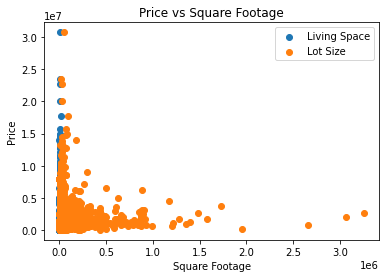

In [205]:
# plot the scatter plot
plt.scatter(clean_king['sqft_living'], clean_king['price'], label='Living Space')
plt.scatter(clean_king['sqft_lot'], clean_king['price'], label='Lot Size')

# set the x and y axis labels
plt.xlabel('Square Footage')
plt.ylabel('Price')

# set the plot title
plt.title('Price vs Square Footage')

# add a legend
plt.legend()

# display the plot
plt.show()

I wanted to see how the living space of the home compared to the size of the lot, or land, on which the house is built to understand how each is influencing the price. Sqft_lot has some outliers that we will want to normalize in order to get a better understanding. 

In [206]:
clean_king['sqft_lot'].median()

7480.0

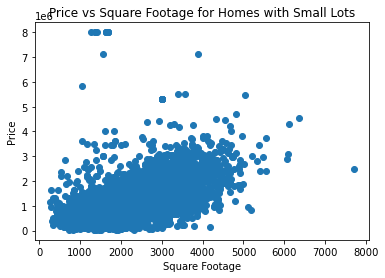

In [207]:
# filter for homes with a sqft_lot of 8000 or less
small_lot = clean_king[clean_king['sqft_lot'] <= 7500]

# plot the scatter plot
plt.scatter(small_lot['sqft_living'], small_lot['price'])

# set the x and y axis labels
plt.xlabel('Square Footage')
plt.ylabel('Price')

# set the plot title
plt.title('Price vs Square Footage for Homes with Small Lots')

# display the plot
plt.show()

# Correlations and Multicollinearity

I want to find the variables with the highest correlation to price. I also want to make sure to eliminate any variables higher than 0.80 to lower the risk of multicollinearity. Since I added numerical values to our explanatory columns, we will also be able to measure their correlation. The matrix below provides a visual for how closely correlated each variable is to one another. 

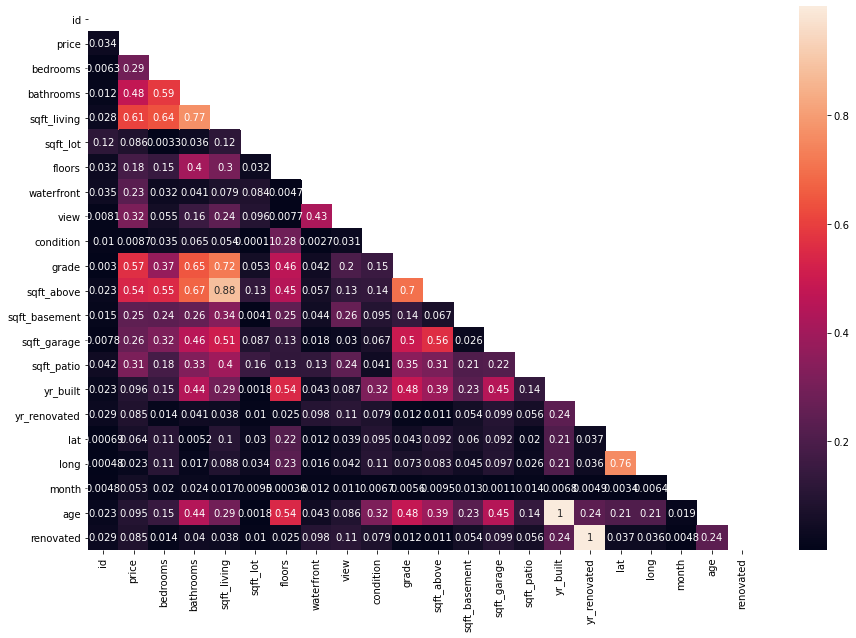

In [208]:
# A look at the Pearson correlation coefficients between variables by using a heatmap
corr = clean_king.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(15, 10))
sns.heatmap(clean_king.corr().abs(), annot=True, mask=mask);

I want to remove sqft_above as it has a strong correlation to sqft_living, which is my preferred variable. Latitude and Longitude have a semi-strong correlation, but that's to be expected. I'm also going to remove yr_built and yr_renovated as they conflict with age and renovated. The ID column is also useless for our model, so I'll drop this column as well. 

In [209]:
clean_df = clean_king.drop(columns=['id','sqft_above','yr_renovated','yr_built'])
clean_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,sewer_system,sqft_basement,sqft_garage,sqft_patio,address,lat,long,month,age,renovated
0,2022-05-24,675000.0,4,1.0,1180,7140,1.0,0,NO,NO,...,PUBLIC,0,0,40,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,5,53,0
1,2021-12-13,920000.0,5,2.5,2770,6703,1.0,0,NO,YES,...,PUBLIC,1570,0,240,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,12,71,0
2,2021-09-29,311000.0,6,2.0,2880,6156,1.0,0,NO,NO,...,PUBLIC,1580,0,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,9,65,0
3,2021-12-14,775000.0,3,3.0,2160,1400,2.0,0,NO,NO,...,PUBLIC,1070,200,270,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020,12,11,0
4,2021-08-24,592500.0,2,2.0,1120,758,2.0,0,NO,YES,...,PUBLIC,550,550,30,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188,8,9,0


# Modeling

In [247]:
df_cat = clean_df[['month','waterfront', 'greenbelt', 'nuisance', 'view', 'condition', 'grade', 'heat_source', 'sewer_system']].copy()
df_num = clean_df[['price', 'bedrooms', 'bathrooms','sqft_living','sqft_lot', 'floors', 'sqft_basement', 'sqft_garage', 'sqft_patio', 'age', 'lat', 'long']].copy()

## Clean Model

In [248]:
# define the independent variables
X = df_num

# define the dependent variable
y = clean_df['price']

# add a constant to the independent variables
X = sm.add_constant(X)

# fit the multiple linear regression model
model = sm.OLS(y, X).fit()

# print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.413e+32
Date:                Thu, 23 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:50:44   Log-Likelihood:             5.6893e+05
No. Observations:               30155   AIC:                        -1.138e+06
Df Residuals:                   30142   BIC:                        -1.138e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -9.75e-10   3.18e-10     -3.067

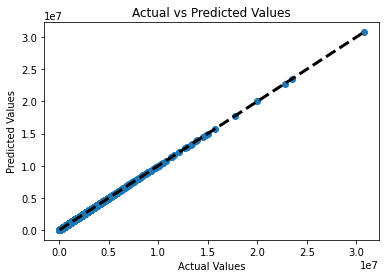

In [249]:
# Get the predicted values from the model
y_pred = model.predict(X)

# Plot the actual values and predicted values
plt.scatter(y, y_pred)

# Plot the perfect line
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=3)

# Set the labels and title of the plot
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

# Show the plot
plt.show()

In [250]:
# define the independent variables
X = df_num['bathrooms', 'sqft_living', 'sqft_basement', 'sqft_garage', 'age', 'floors', 'long', 'sqft_patio']

# define the dependent variable
y = clean_df['price']

# add a constant to the independent variables
X = sm.add_constant(X)

# fit the multiple linear regression model
model = sm.OLS(y, X).fit()

# print the model summary
print(model.summary())

KeyError: ('bathrooms', 'sqft_living', 'sqft_basement', 'sqft_garage', 'age', 'floors', 'long', 'sqft_patio')

Cleaning our data didn't change the quality of our model. 

## Data Tranformation

## Categorical Data 